In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [2]:
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')

### probably will be some class properties

In [118]:
__margin = np.sqrt(2)

# temp solution reading csv file

In [3]:
data_source = 'data_csv'

ideal = pd.read_csv(os.path.join(data_source, 'ideal.csv'))
test = pd.read_csv(os.path.join(data_source,'test.csv'))
train = pd.read_csv(os.path.join(data_source,'train.csv'))

In [4]:
ideal.head()

,x,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29,y30,y31,y32,y33,y34,y35,y36,y37,y38,y39,y40,y41,y42,y43,y44,y45,y46,y47,y48,y49,y50
0,-20.0,-0.912945,0.408082,9.087055,5.408082,-9.087055,0.912945,-0.839071,-0.850919,0.816164,18.258905,-20.0,-58.0,-45.0,20.0,13.00,400.00,-400.00,800.00,410.00,289.00,-8000.000,8000.000,8000.000,-16000.000,-23995.000,-5832.000,10648.000,-8020.000,-7600.000,-8795.000,20.0,4.472136,20.124610,-0.746414,10.0,100.0,-20.0,-1.321027,399.08707,899.59190,-40.456474,40.204040,2.995732,-0.008333,12.995732,5.298317,-5.298317,-0.186278,0.912945,0.396850
1,-19.9,-0.867644,0.497186,9.132356,5.497186,-9.132356,0.867644,-0.865213,0.168518,0.994372,17.266117,-19.9,-57.7,-44.8,19.9,12.95,396.01,-396.01,792.02,406.01,285.61,-7880.599,7880.599,7880.599,-15761.198,-23636.797,-5735.339,10503.459,-7900.499,-7484.589,-8667.619,19.9,4.460942,20.025234,-0.620450,9.9,99.5,-19.9,-1.364830,395.14236,893.51280,-40.233820,40.048590,2.990720,-0.008340,12.990720,5.293305,-5.293305,-0.215690,0.867644,0.476954
2,-19.8,-0.813674,0.581322,9.186326,5.581322,-9.186326,0.813674,-0.889191,0.612391,1.162644,16.110740,-19.8,-57.4,-44.6,19.8,12.90,392.04,-392.04,784.08,402.04,282.24,-7762.392,7762.392,7762.392,-15524.784,-23282.176,-5639.752,10360.232,-7782.192,-7370.352,-8541.472,19.8,4.449719,19.925863,-0.475739,9.8,99.0,-19.8,-1.394996,391.22632,887.45870,-40.006836,39.890660,2.985682,-0.008347,12.985682,5.288267,-5.288267,-0.236503,0.813674,0.549129
3,-19.7,-0.751573,0.659649,9.248426,5.659649,-9.248426,0.751573,-0.910947,-0.994669,1.319299,14.805996,-19.7,-57.1,-44.4,19.7,12.85,388.09,-388.09,776.18,398.09,278.89,-7645.373,7645.373,7645.373,-15290.746,-22931.120,-5545.233,10218.313,-7665.073,-7257.283,-8416.553,19.7,4.438468,19.826498,-0.316436,9.7,98.5,-19.7,-1.411223,387.33844,881.43036,-39.775787,39.729824,2.980619,-0.008354,12.980619,5.283204,-5.283204,-0.247887,0.751573,0.612840
4,-19.6,-0.681964,0.731386,9.318036,5.731386,-9.318036,0.681964,-0.930426,0.774356,1.462772,13.366487,-19.6,-56.8,-44.2,19.6,12.80,384.16,-384.16,768.32,394.16,275.56,-7529.536,7529.536,7529.536,-15059.072,-22583.607,-5451.776,10077.696,-7549.136,-7145.376,-8292.856,19.6,4.427189,19.727139,-0.147038,9.6,98.0,-19.6,-1.413350,383.47803,875.42860,-39.540980,39.565693,2.975530,-0.008361,12.975530,5.278115,-5.278115,-0.249389,0.681964,0.667902


In [5]:
test.head()

,x,y
0,17.5,34.161040
1,0.3,1.215102
2,-8.7,-16.843908
3,-19.2,-37.170870
4,-11.0,-20.263054


In [6]:
train.head()

,x,y1,y2,y3,y4
0,-20.0,39.778572,-40.078590,-20.214268,-0.324914
1,-19.9,39.604813,-39.784000,-20.070950,-0.058820
2,-19.8,40.099070,-40.018845,-19.906782,-0.451830
3,-19.7,40.151100,-39.518402,-19.389118,-0.612044
4,-19.6,39.795662,-39.360065,-19.815890,-0.306076


In [7]:
train.shape, ideal.shape, test.shape

((400, 5), (400, 51), (100, 2))

In [8]:
(ideal['x'] == train['x']).all() # test case 

True

In [9]:
(test['x'].isin(ideal['x'])).all() # test case 

True

In [10]:
features = ideal['x']
train_lables = train.drop(columns=['x'])
ideal_lables = ideal.drop(columns=['x'])

In [11]:
diff_train1 = pd.DataFrame.from_dict({'reference': train_lables['y1']})
diff_train2 = pd.DataFrame.from_dict({'reference': train_lables['y2']})
diff_train3 = pd.DataFrame.from_dict({'reference': train_lables['y3']})
diff_train4 = pd.DataFrame.from_dict({'reference': train_lables['y4']})

In [12]:
%%timeit
for (ideal_name, ideal_lable) in ideal_lables.iteritems():
    diff_train1[f'sq_dif_{ideal_name}'] = np.power((diff_train1['reference'] - ideal_lable), 2)
    diff_train2[f'sq_dif_{ideal_name}'] = np.power((diff_train2['reference'] - ideal_lable), 2)
    diff_train3[f'sq_dif_{ideal_name}'] = np.power((diff_train3['reference'] - ideal_lable), 2)
    diff_train4[f'sq_dif_{ideal_name}'] = np.power((diff_train4['reference'] - ideal_lable), 2)

53 ms ± 823 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [123]:
diff_train1.head()

,reference,sq_dif_y1,sq_dif_y2,sq_dif_y3,sq_dif_y4,sq_dif_y5,sq_dif_y6,sq_dif_y7,sq_dif_y8,sq_dif_y9,sq_dif_y10,sq_dif_y11,sq_dif_y12,sq_dif_y13,sq_dif_y14,sq_dif_y15,sq_dif_y16,sq_dif_y17,sq_dif_y18,sq_dif_y19,sq_dif_y20,sq_dif_y21,sq_dif_y22,sq_dif_y23,sq_dif_y24,sq_dif_y25,sq_dif_y26,sq_dif_y27,sq_dif_y28,sq_dif_y29,sq_dif_y30,sq_dif_y31,sq_dif_y32,sq_dif_y33,sq_dif_y34,sq_dif_y35,sq_dif_y36,sq_dif_y37,sq_dif_y38,sq_dif_y39,sq_dif_y40,sq_dif_y41,sq_dif_y42,sq_dif_y43,sq_dif_y44,sq_dif_y45,sq_dif_y46,sq_dif_y47,sq_dif_y48,sq_dif_y49,sq_dif_y50
0,39.778572,1655.799580,1550.035477,941.969216,1181.330583,2387.849502,1510.536939,1649.792963,1650.755569,1518.069226,463.096068,3573.477670,9560.649142,7187.406270,391.191910,717.091918,129759.477190,193405.192390,577936.619590,137063.905750,62111.320174,6.463804e+07,6.336513e+07,6.336513e+07,2.572745e+08,5.776706e+08,3.447778e+07,1.125344e+08,6.496003e+07,5.836622e+07,7.805331e+07,391.191910,1246.544423,386.278222,1642.274515,886.763350,3626.620390,3573.477670,1689.177063,129102.596735,739278.959006,6437.662607,0.181023,1352.977296,1582.997836,717.320518,1188.887957,2031.925958,1597.189258,1510.536939,1550.920059
1,39.604813,1638.019784,1529.406505,928.570636,1163.330240,2375.311642,1500.568254,1637.822972,1555.221389,1490.766185,499.017339,3540.822770,9468.226633,7124.172458,388.279655,710.479056,127024.657321,189760.265305,566128.613628,134252.761061,60518.552031,6.272963e+07,6.148119e+07,6.148119e+07,2.496654e+08,5.605720e+08,3.334998e+07,1.094922e+08,6.304525e+07,5.661349e+07,7.581575e+07,388.279655,1235.091669,383.359914,1618.071816,882.375915,3587.433426,3540.822770,1678.511639,126406.947327,729158.850262,6374.207319,0.196938,1340.591821,1569.201913,708.309946,1177.279581,2015.841000,1585.672473,1500.568254,1530.989354
2,40.099070,1673.852600,1561.652420,955.597742,1191.474948,2429.050259,1543.342360,1680.037552,1559.197811,1516.045293,575.439976,3587.898587,9506.068651,7173.932459,412.052243,739.789409,123862.418209,186744.175820,553507.624204,131001.236809,58632.229981,6.087887e+07,5.963381e+07,5.963381e+07,2.422656e+08,5.439285e+08,3.226071e+07,1.065051e+08,6.118824e+07,5.491479e+07,7.364336e+07,412.052243,1270.876227,406.958281,1646.315099,918.033643,3469.319555,3587.898587,1721.757480,123290.345693,718018.342554,6416.956176,0.043435,1377.403569,1608.604918,735.135809,1211.792006,2060.010360,1626.958461,1543.342360,1564.197825
3,40.151100,1673.028695,1559.574668,954.975260,1189.660164,2440.313169,1552.322693,1686.091715,1692.974269,1507.908777,642.374297,3582.154171,9457.776451,7148.888511,418.247491,745.350061,121061.478133,183390.439729,541738.541635,128120.256133,56996.262373,5.906728e+07,5.783940e+07,5.783940e+07,2.350364e+08,5.276793e+08,3.119652e+07,1.035950e+08,5.937048e+07,5.325254e+07,7.151584e+07,418.247491,1275.392084,413.089446,1637.621472,927.269491,3404.594131,3582.154171,1727.426677,120539.049056,707750.793306,6388.307266,0.177473,1381.644680,1612.781763,738.235065,1215.770199,2064.275944,1632.078190,1552.322693,1563.274012
4,39.795662,1638.438174,1526.017652,928.885687,1160.374899,2412.155331,1529.881403,1658.614268,1522.662345,1469.410433,698.501291,3527.844664,9330.721917,7055.271235,407.864764,728.765767,118586.797286,179738.403342,530747.711058,125574.084046,55584.823073,5.729478e+07,5.609621e+07,5.609621e+07,2.279758e+08,5.118183e+08,3.015736e+07,1.007594e+08,5.759188e+07,5.162669e+07,6.943308e+07,407.864764,1250.928882,402.745615,1595.419283,911.778004,3387.744962,3527.844664,1698.182645,118117.570074,698282.407071,6294.302764,0.052886,1355.722143,1584.360263,719.319480,1191.461051,2031.645373,1603.606138,1529.881403,1530.981610


In [14]:
MSE = pd.DataFrame()

In [15]:
for idx, frame in enumerate((diff_train1, diff_train2, diff_train3, diff_train4)):
    frame.loc['sum'] = frame.sum()
    MSE[f'train_y{idx+1}'] = frame.loc['sum'] / train.shape[0]

In [122]:
frame.head()

,reference,sq_dif_y1,sq_dif_y2,sq_dif_y3,sq_dif_y4,sq_dif_y5,sq_dif_y6,sq_dif_y7,sq_dif_y8,sq_dif_y9,sq_dif_y10,sq_dif_y11,sq_dif_y12,sq_dif_y13,sq_dif_y14,sq_dif_y15,sq_dif_y16,sq_dif_y17,sq_dif_y18,sq_dif_y19,sq_dif_y20,sq_dif_y21,sq_dif_y22,sq_dif_y23,sq_dif_y24,sq_dif_y25,sq_dif_y26,sq_dif_y27,sq_dif_y28,sq_dif_y29,sq_dif_y30,sq_dif_y31,sq_dif_y32,sq_dif_y33,sq_dif_y34,sq_dif_y35,sq_dif_y36,sq_dif_y37,sq_dif_y38,sq_dif_y39,sq_dif_y40,sq_dif_y41,sq_dif_y42,sq_dif_y43,sq_dif_y44,sq_dif_y45,sq_dif_y46,sq_dif_y47,sq_dif_y48,sq_dif_y49,sq_dif_y50
0,-0.324914,0.345781,0.537284,88.585165,32.867246,76.775111,1.532296,0.264358,0.276681,1.302060,345.358338,387.108999,3326.415516,1995.863287,413.102139,177.553340,160260.036969,159740.174169,640519.968369,168366.535254,83708.906006,6.399480e+07,6.400520e+07,6.400520e+07,2.559896e+08,5.757444e+08,3.400843e+07,1.133868e+08,6.431519e+07,5.775506e+07,7.734631e+07,413.102139,23.011691,418.183042,0.177662,106.603854,10065.088419,387.108999,0.992241,159529.933163,809850.272570,1610.542088,1642.596133,11.026694,0.100223,177.439617,31.620734,24.734739,0.019220,1.532296,0.520943
1,-0.058820,0.654197,0.309142,84.477714,30.869198,82.329058,0.858335,0.650269,0.051682,1.109212,300.153437,393.672429,3322.505647,2001.773200,398.354490,169.229394,156870.510068,156777.337051,627388.856877,164891.886466,81606.674642,6.210291e+07,6.210477e+07,6.210477e+07,2.484135e+08,5.586954e+08,3.289344e+07,1.103239e+08,6.241696e+07,5.601819e+07,7.512660e+07,398.354490,20.428247,403.369220,0.315429,99.178093,9911.958613,393.672429,1.705662,156183.972566,798470.239826,1614.030636,1608.604326,9.299692,0.002548,170.290491,28.645241,27.399835,0.024608,0.858335,0.287054
2,-0.451830,0.130931,1.067402,92.894043,36.398915,76.291427,1.601499,0.191285,1.132566,2.606524,274.318712,374.351698,3243.094112,1949.060950,410.136602,178.271354,154049.836303,153341.295197,615490.191656,161999.672895,79914.670523,6.024772e+07,6.026174e+07,6.026174e+07,2.410049e+08,5.420387e+08,3.180171e+07,1.073438e+08,6.055548e+07,5.431543e+07,7.294903e+07,410.136602,24.025179,415.250356,0.000572,105.100010,9890.666411,374.351698,0.889562,153411.772874,788385.108575,1564.598531,1627.516467,11.816486,0.196677,180.566718,32.948709,23.391127,0.046365,1.601499,1.001918
3,-0.612044,0.019468,1.617205,97.228873,39.334141,74.587091,1.859453,0.089343,0.146401,3.730086,237.715964,364.350057,3190.889150,1917.385073,412.579140,181.226634,151089.279165,150139.166231,603405.879932,158963.320049,78121.392712,5.844237e+07,5.846109e+07,5.846109e+07,2.337882e+08,5.258082e+08,3.074282e+07,1.044264e+08,5.874396e+07,5.265927e+07,7.082806e+07,412.579140,25.507673,417.734007,0.087384,106.338256,9823.197306,364.350057,0.638686,150505.578191,777998.802807,1533.798750,1627.466330,12.907227,0.364442,184.760479,34.753947,21.819730,0.132610,1.859453,1.500341
4,-0.306076,0.141292,1.076327,92.623524,36.450943,81.215430,0.976221,0.389814,1.167332,3.128823,186.938968,372.255519,3191.563494,1926.676599,396.251846,171.769218,147814.163287,147343.835277,590786.044092,155603.484799,76102.091667,5.668930e+07,5.669852e+07,5.669852e+07,2.267664e+08,5.100055e+08,2.971852e+07,1.015661e+08,5.698483e+07,5.105202e+07,6.876638e+07,396.251846,22.403794,401.329687,0.025293,98.130334,9664.084500,372.255519,1.226056,147290.239711,766911.222048,1539.377723,1589.757931,10.768933,0.088634,176.401047,31.183185,24.721176,0.003213,0.976221,0.948632


In [17]:
MSE = MSE.drop(['reference'])
MSE.index = [idx.split('_')[-1] for idx in MSE.index]
MSE.index.name = 'No ideal func'

In [18]:
MSE.head()

,train_y1,train_y2,train_y3,train_y4
No ideal func,,,,
y1,531.472176,534.268865,134.514539,0.552048
y2,532.346369,533.420559,133.876070,0.614010
y3,629.273209,636.107997,235.501458,100.253745
y4,556.725800,559.819042,159.848446,25.943774
y5,636.494906,630.439191,232.010051,100.850119


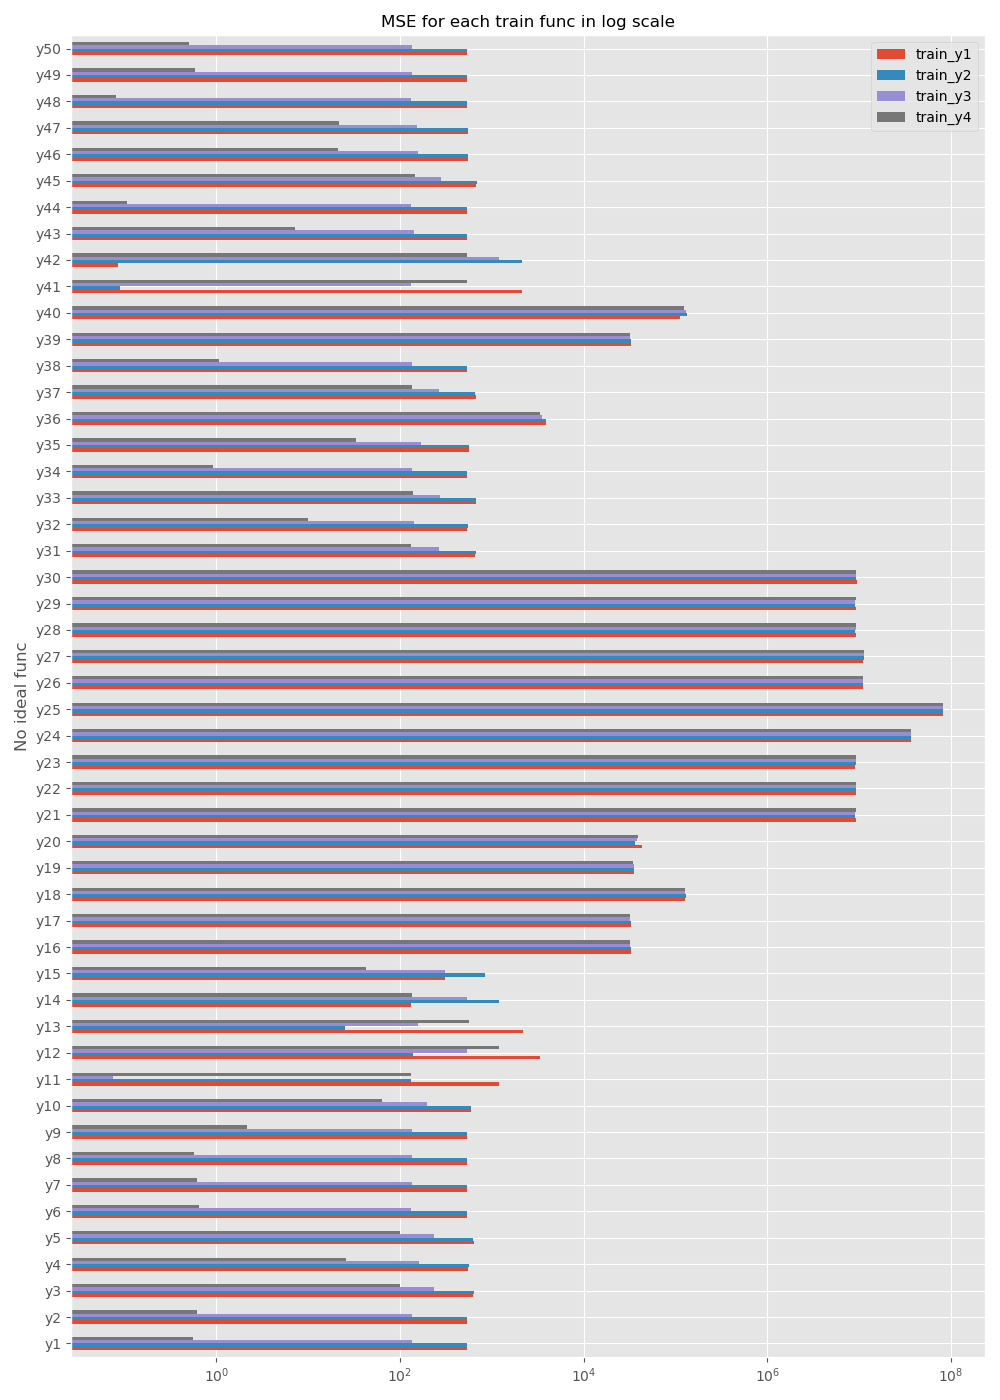

In [36]:
# ploting MSE
ax = MSE.plot(
    figsize=(10, 14),
    kind='barh', 
    logx=True,
    fontsize=10
)
ax.set_title('MSE for each train func in log scale', fontsize=12)
plt.tight_layout()

In [37]:
best_fit = pd.DataFrame(
    {
        'No. of ideal func': MSE.iloc[MSE.agg(np.argmin)].index,
        'MSE': MSE.agg(np.min)
    }
).transpose()

best_fit

,train_y1,train_y2,train_y3,train_y4
No. of ideal func,y42,y41,y11,y48
MSE,0.085616,0.089005,0.074655,0.079909


In [115]:
chosen_ideal = best_fit.loc['No. of ideal func'].to_list()
chosen_ideal

['y42', 'y41', 'y11', 'y48']

In [87]:
# create graphs fitting ideal to train *4

In [120]:
merged_df = pd.merge(
    left=test.sort_values(by='x'),
    right=ideal[chosen_ideal + ['x']],
    how='left',
    on='x',
)
merged_df.head()

,x,y,y42,y41,y11,y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051


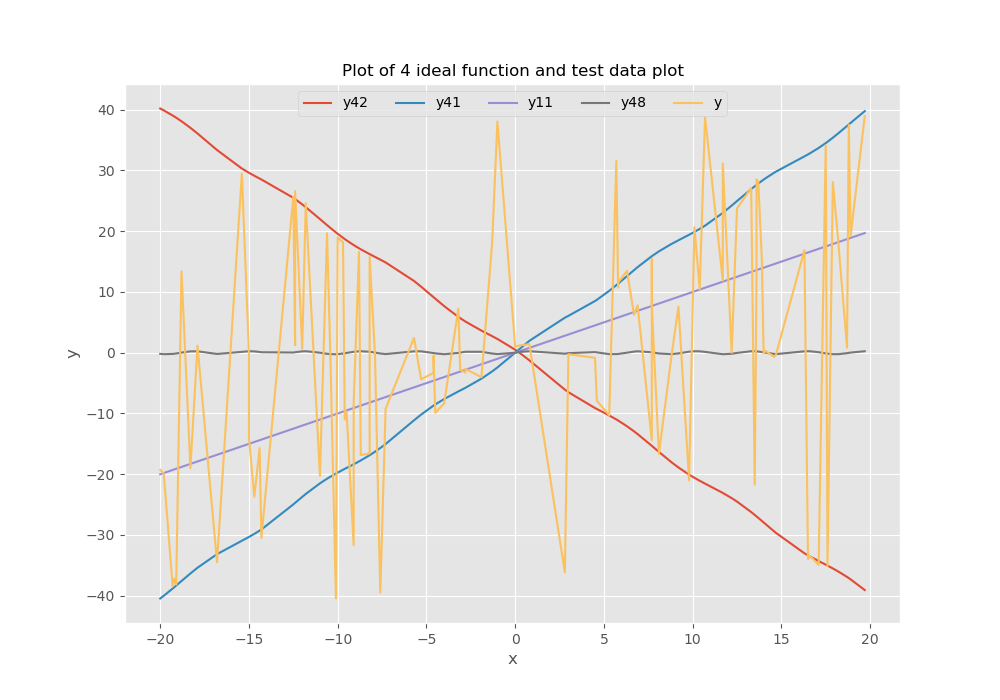

In [103]:
ax2 = merged_df.plot(x='x', 
                     y=['y42', 'y41', 'y11', 'y48', 'y'], 
                     ylabel='y', 
                     figsize=(10,7)
                    )
ax2.set_title('Plot of 4 ideal function and test data plot', fontsize=12)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)

In [137]:
ans = pd.Series(
                dtype=np.int32,
                name='amount of fitted points', 
                index=pd.Index([], name='ideal_func')
               )

for ideal_func in chosen_ideal:
    merged_df[f'div_{ideal_func}'] = np.absolute(merged_df['y'] - merged_df[ideal_func])
    ans[ideal_func] = sum(merged_df[f'div_{ideal_func}'] < __margin)
    
merged_df.head()

,x,y,y42,y41,y11,y48,div_y42,div_y41,div_y11,div_y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278,59.489010,21.171504,0.715030,19.098692
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503,59.805674,20.091822,0.115014,19.678511
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970,77.508697,0.359112,19.158572,38.262602
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224,76.040480,1.400790,17.970870,37.009646
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051,76.839778,0.168541,19.055376,38.035325


In [143]:
ans.to_frame().transpose()

ideal_func,y42,y41,y11,y48
fitted datapoints amount,21,26,26,18


# Creating DF for final db

In [149]:
for idx, row in merged_df.iterrows():
    row['test'] = 0


In [150]:
merged_df.head()

,x,y,y42,y41,y11,y48,div_y42,div_y41,div_y11,div_y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278,59.489010,21.171504,0.715030,19.098692
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503,59.805674,20.091822,0.115014,19.678511
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970,77.508697,0.359112,19.158572,38.262602
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224,76.040480,1.400790,17.970870,37.009646
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051,76.839778,0.168541,19.055376,38.035325


# Playing with inheritance from pd.df

In [145]:
class MyDF(pd.DataFrame):
    pass
    
    @property
    def _constructor(self):
        return MyDF

    def __init__(self, *args, **kw):
        super().__init__(*args, **kw)